BTC price prediction using only historic 'price' data

In [19]:
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### data extraction

In [2]:
# get historic data from the cryptocompare public API 
endpoint = 'https://min-api.cryptocompare.com/data/histoday'

# historic daily BTC data for the last 2000 days, from 2012–12–11.
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=2000')

In [4]:
# load the data to a dataframe
hist = pd.DataFrame(json.loads(res.content)['Data'])

In [5]:
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
hist.head()

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2012-12-11,13.56,13.67,13.30,13.43,28045.88,378671.69
2012-12-12,13.70,13.80,13.30,13.56,37679.23,512418.01
2012-12-13,13.70,13.80,13.47,13.70,24197.68,331480.86
2012-12-14,13.60,13.90,13.00,13.70,70143.98,951046.01
2012-12-15,13.49,13.64,13.44,13.60,15187.66,205671.39


In [7]:
# split the test and training data
def train_test_split(df, test_size=0.1):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [8]:
# plot the data (for visualization)
def line_plot(line1, line2, label1=None, label2=None, title=''):
    fig, ax = plt.subplots(1, figsize=(16, 9))
    ax.plot(line1, label=label1, linewidth=2)
    ax.plot(line2, label=label2, linewidth=2)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18)

In [9]:
train, test = train_test_split(hist, test_size=0.1)

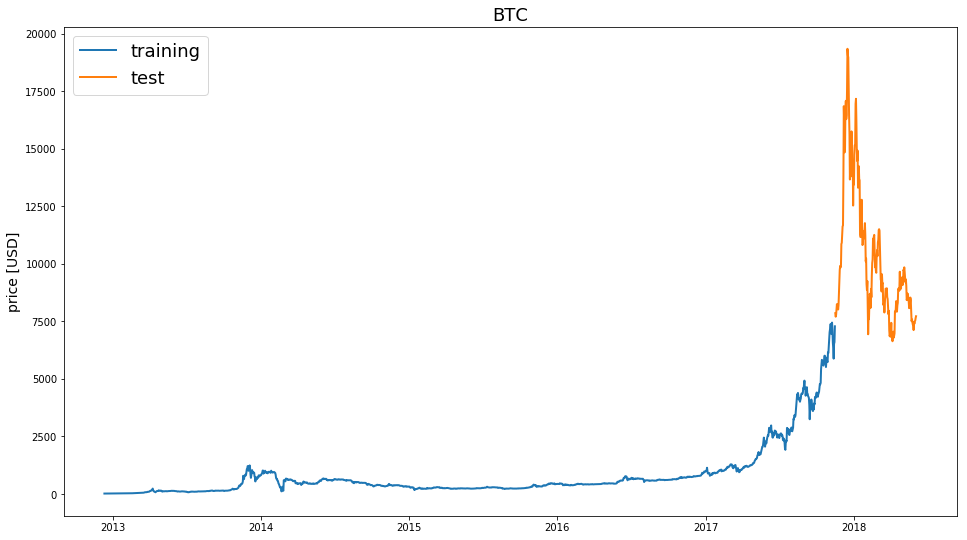

In [12]:
line_plot(train.close, test.close, 'training', 'test', 'BTC')

### preprocess and prepare the data

In [13]:
def normalise_zero_base(df):
    """
    Normalise dataframe column-wise to reflect changes with
    respect to first entry.
    """
    return df / df.iloc[0] - 1

In [15]:
def extract_window_data(df, window=7, zero_base=True):
    """
    Convert dataframe to overlapping sequences/windows of
    length `window`. Default time period -> 7 days
    """
    window_data = []
    for idx in range(len(df) - window):
        tmp = df[idx: (idx + window)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [17]:
def prepare_data(df, window=7, zero_base=True, test_size=0.1):
    """
    Prepare data for the LSTM model.
    """
    # train test split
    train_data, test_data = train_test_split(df, test_size)
    
    # extract window data
    X_train = extract_window_data(train_data, window, zero_base)
    X_test = extract_window_data(test_data, window, zero_base)
    
    # extract targets
    y_train = train_data.close[window:].values
    y_test = test_data.close[window:].values
    if zero_base:
        y_train = y_train / train_data.close[:-window].values - 1
        y_test = y_test / test_data.close[:-window].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [20]:
# prepare the data
train, test, X_train, X_test, y_train, y_test = prepare_data(hist)

### the model

In [24]:
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

/home/satan_baba/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [21]:
### define the model
def build_lstm_model(input_data, output_size, neurons=20,
                     activ_func='linear', dropout=0.25,
                     loss='mae', optimizer='adam'):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(
              input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [25]:
# compile the model
model = build_lstm_model(X_train, output_size=1)

In [32]:
# model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20)                2160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 2,181
Trainable params: 2,181
Non-trainable params: 0
_________________________________________________________________


In [33]:
# train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=4)

Epoch 1/50
1794/1794 [==============================] - 8s 5ms/step - loss: 0.0760
Epoch 2/50
1794/1794 [==============================] - 7s 4ms/step - loss: 0.0535
Epoch 3/50
1794/1794 [==============================] - 7s 4ms/step - loss: 0.0473
Epoch 4/50
1794/1794 [==============================] - 7s 4ms/step - loss: 0.0440
Epoch 5/50
1794/1794 [==============================] - 7s 4ms/step - loss: 0.0429
Epoch 6/50
1794/1794 [==============================] - 6s 4ms/step - loss: 0.0423
Epoch 7/50
1794/1794 [==============================] - 5s 3ms/step - loss: 0.0411
Epoch 8/50
1794/1794 [==============================] - 6s 3ms/step - loss: 0.0385
Epoch 9/50
1794/1794 [==============================] - 6s 3ms/step - loss: 0.0391
Epoch 10/50
1794/1794 [==============================] - 5s 3ms/step - loss: 0.0373
Epoch 11/50
1794/1794 [==============================] - 5s 3ms/step - loss: 0.0382
Epoch 12/50
1794/1794 [==============================] - 7s 4ms/step - loss: 0.0381
E

### training evaluation

In [35]:
test

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2017-11-16,7853.68,7964.64,7119.17,7283.02,133937.80,1.010131e+09
2017-11-17,7699.95,8000.19,7534.70,7853.68,117347.03,9.175999e+08
2017-11-18,7780.91,7857.52,7458.90,7699.95,74382.12,5.711211e+08
2017-11-19,8042.64,8100.87,7675.41,7781.02,68618.85,5.413913e+08
2017-11-20,8244.69,8294.12,7947.28,8042.64,75703.64,6.173543e+08
2017-11-21,8099.97,8368.36,7819.06,8245.87,115454.28,9.383454e+08
2017-11-22,8234.55,8304.37,8091.63,8099.92,65811.68,5.396974e+08
2017-11-23,8013.41,8266.55,8012.35,8234.50,68010.70,5.554651e+08
2017-11-24,8200.80,8332.94,7900.17,8013.38,72994.63,5.957104e+08


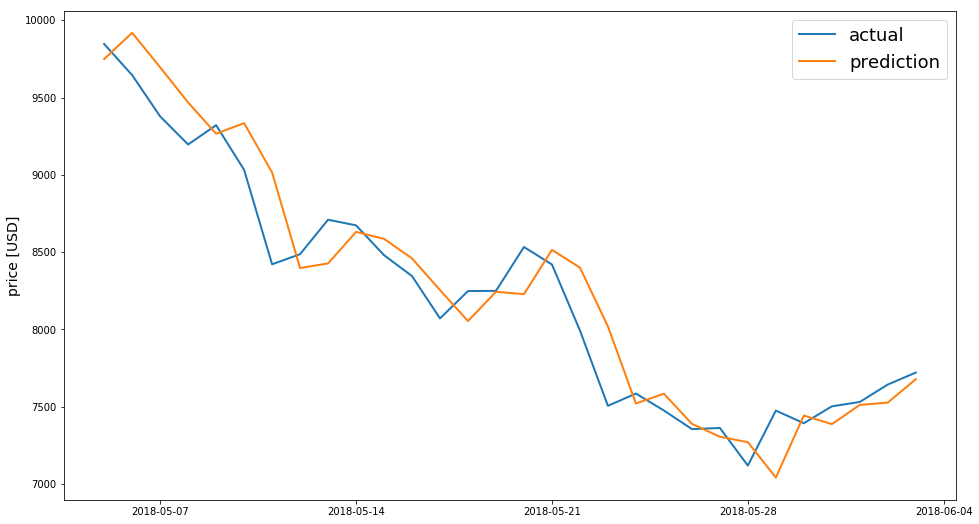

In [41]:
target_col = 'close'
window = 7

targets = test[target_col][window:]
preds = model.predict(X_test).squeeze()

# convert change predictions back to actual price
preds = test.close.values[:-window] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)

n = 30

line_plot(targets[-n:], preds[-n:], 'actual', 'prediction')